In [1]:
import scipy.io 
import numpy as np 
import matplotlib.pyplot as plt 
import alphashape
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.optimize import curve_fit
from shapely.geometry import Polygon, MultiPolygon
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import warnings
from collections import defaultdict
from tqdm import tqdm
from scipy.interpolate import interp1d

In [2]:
#file_path = r'C:\Users\josep\Desktop\Summer Research Project\white_pixels.mat'
data = scipy.io.loadmat('C:\\Users\josep\Desktop\Summer Research Project\july4)_processededges.mat') 

# Extract the frames 
processed_edges = data['processedEdges'] 

In [3]:
processed_edges[0,0].shape

(1080, 1920)

In [4]:
no_frames = processed_edges.shape[1]
no_frames

690

# 1) Input Manually

## 1.1) Halfway Line

In [7]:
half_line_y = 587.5 
# at what value do you define the halfway line between the reflection 

In [8]:
i = 90
# test a random frame

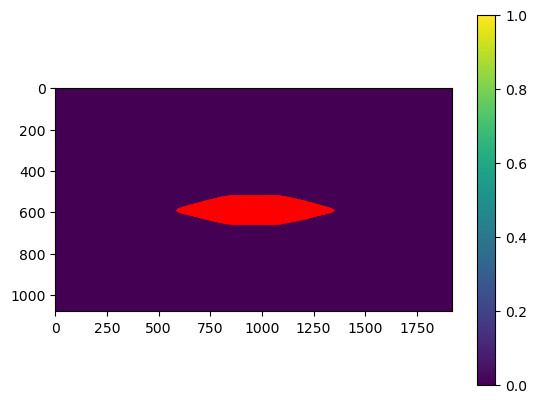

In [9]:
# Extract the 2D array
data = processed_edges[0, i]

# Find indices where values are greater than 0.8
y, x = np.where(data > 0.8)

# Plot the 2D array
plt.imshow(data, cmap='viridis')
plt.colorbar()

# Overlay the points
plt.scatter(x, y, color='red', s=2)

# Show the plot
plt.show()

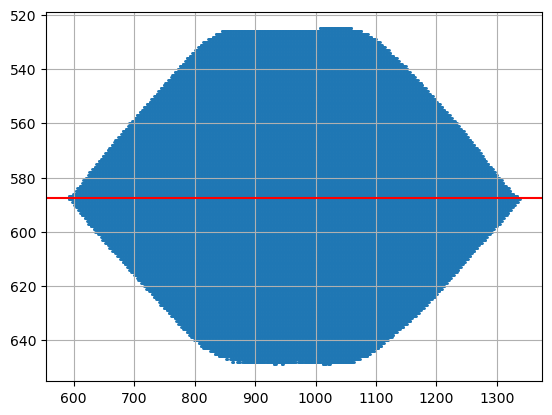

In [10]:
plt.figure()
plt.scatter(x, y, s = 1)
plt.grid(True)
plt.gca().invert_yaxis()

# Draw the horizontal line at 230
plt.axhline(y=half_line_y, color='r', linestyle='-')


#plt.ylim(599,580)
#plt.xlim(520, 720)
plt.show()

# 2) Define Functions

In [13]:
def plot_extreme_x_points(x_edge, y_edge, target_y):
    """
    Plots the smallest and largest x values at target_y along with the other points.
    
    Parameters:
    x_edge (list): List of x coordinates.
    y_edge (list): List of y coordinates.
    target_y (int or float): The y value to filter the x values.
    """
    # Separate points at target_y and other points
    x_at_target_y = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] == target_y]
    x_other = [x_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]
    y_other = [y_edge[i] for i in range(len(y_edge)) if y_edge[i] != target_y]

    # Find the smallest and largest x values at target_y
    if x_at_target_y:  # Ensure there's at least one point at target_y
        x_min = min(x_at_target_y)
        x_max = max(x_at_target_y)

        # Create new lists for plotting the points at target_y
        x_filtered = [x_min, x_max]
        y_filtered = [target_y, target_y]

    new_x = np.concatenate((x_filtered, x_other))
    new_y = np.concatenate((y_filtered, y_other))

    return new_x, new_y

# 3) Perform Loop

## 3.1) Left Angle

In [19]:
len(x)

62317

In [20]:
angles_list = []

#for i in tqdm(range(no_frames)):

for i in tqdm(range(no_frames)):
    # Extract the 2D array
    data = processed_edges[0, i]

    # Find indices where values are greater than 0.8
    y, x = np.where(data > 0.8)

    if len(x) < 3000:
        pass 

    else:
        # Only consider upper half 
        x_upper = x[y <= half_line_y]
        y_upper = y[y <= half_line_y]

        # Only perform for the left side 
        quarter_point = (-np.min(x_upper) + np.max(x_upper)) / 4 + np.min(x_upper)
        quarter_mask = [x_upper <= quarter_point][0]

        x_quarter = x_upper[quarter_mask]
        y_quarter = y_upper[quarter_mask]

        x_filtered = x_quarter[y_quarter <= half_line_y]
        y_filtered = y_quarter[y_quarter <= half_line_y]

        # Create points array
        points = np.vstack((x_filtered, y_filtered)).T

        # Compute the alpha shape with a suitable alpha value
        alpha = 0.1  #
        alpha_shape = alphashape.alphashape(points, alpha)
        if isinstance(alpha_shape, Polygon):
            x_edge, y_edge = alpha_shape.exterior.xy
        elif isinstance(alpha_shape, MultiPolygon):
            for poly in alpha_shape:
                x_edge, y_edge = poly.exterior.xy

        x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, 587)
        mask_middle = np.where( np.isclose(x_main_edge, quarter_point, atol= 1.5) )

        #Get all indices
        all_indices = np.arange(x_main_edge.shape[0])
        
        # Get indices that are not in mask_middle
        ind_not_middle = np.setdiff1d(all_indices, mask_middle)
        
        x_half = x_main_edge[ind_not_middle]
        y_half = y_main_edge[ind_not_middle]

        y_to_x = defaultdict(list)
        for x_v, y_v in zip(x_half, y_half):
            y_to_x[y_v].append(x_v)
        
        unique_y = np.array(sorted(y_to_x.keys()))
        unique_x = np.array([np.mean(y_to_x[y_v]) for y_v in unique_y])

        no_of_points = 20

        x_edge_points = unique_x[-no_of_points:]
        y_edge_points = unique_y[-no_of_points:]

        # Find the index of the maximum y value
        max_y_index = np.argmax(y_edge_points)
        max_x_point = x_edge_points[max_y_index]
        max_y_point = y_edge_points[max_y_index]

        '''Perform Iterative fitting for polynomials with degrees between 0 and 12'''

        # Initialize variables to store the best degree and its corresponding RMSE
        best_degree = 0
        best_rmse = float('inf')
        best_poly = None
        
        # Iterate through polynomial degrees from 0 to 12
        for degree in range(13):
        
                # Suppress the RankWarning for poorly conditioned polynomial fit
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                # Fit a polynomial to the data points
                coeffs = np.polyfit(y_edge_points, x_edge_points, degree)
            
            # Adjust the polynomial to pass through the (max_y_point, max_x_point)
            poly = np.poly1d(coeffs)
        
            # Evaluate the polynomial at the max_y_point
            x_at_max_y = poly(max_y_point)
        
            # Calculate the adjustment needed for the constant term
            adjustment = max_x_point - x_at_max_y
        
            # Create the adjusted polynomial
            coeffs[-1] += adjustment
            poly_adjusted = np.poly1d(coeffs)
        
            # Calculate the RMSE for the current polynomial
            x_pred = poly_adjusted(y_edge_points)
            rmse = np.sqrt(mean_squared_error(x_edge_points, x_pred))
        
            # Update the best degree and polynomial if the current RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_degree = degree
                best_poly = poly_adjusted

        # Create the fitted polynomial line using the best polynomial
        y_fit = np.linspace(np.min(y_edge_points), np.max(y_edge_points), 10)
        x_fit = best_poly(y_fit)

        index_min_x = np.argmax(y_fit)
        y_at_min_x = y_fit[index_min_x]

        # calculate the derivative at the point
        if index_min_x==0:
            dx_new = x_fit[0]-x_fit[1]
        
        if index_min_x > 0:
            dx_new = x_fit[index_min_x-1] - x_fit[index_min_x]
        
        if dx_new>0:
            dx = -dx_new
        if dx_new<0:
            dx = np.abs(dx_new)
        
        dy_dx = np.gradient(y_fit, dx)
        slope_at_min_x1 = dy_dx[index_min_x]

        angle_tangent_degrees_left = np.degrees(np.arctan(slope_at_min_x1))
        # Measure angle on right side of interpolation 
        
        if angle_tangent_degrees_left<0:
            angle = np.abs(angle_tangent_degrees_left)
        
        if angle_tangent_degrees_left>0:
            angle = 180 - angle_tangent_degrees_left

        angles_list.append(angle)


100%|██████████| 690/690 [30:38<00:00,  2.66s/it]


In [32]:
angle_left = np.array(angles_list)
angle_left

array([ 23.29519837,  41.82988859, 121.57419075, 137.93361364,
       109.27493505, 116.46658754, 108.76029686, 115.99159193,
       117.55192744,  90.22993025,  89.7928276 ,  90.39094628,
        77.71366323,  84.08960845,  75.62626115,  60.26733533,
        55.54147807,  43.75022843,  41.2326035 ,  41.69653933,
        27.19843923,  25.96545941,  28.05727267,  28.03344195,
        28.63446394,  56.32131863,  45.30421869,  22.02266443,
        26.56799637,  20.03778537,  46.59839619,  14.86114247,
        17.39379691,   8.98632783,  12.04050391,  14.57128888,
        13.47701769,  13.396133  ,  12.81125826,  10.13446626,
        11.84873484,  12.16772846,   6.26691237,   5.34035135,
        29.70236542,  56.91810997,  17.05907441,  15.44395422,
        15.56389024,  14.01964561,  13.36406087,  17.21119094,
         9.63787066,   6.69696491,   4.58310991,  10.52329611,
        27.27444883,  20.29866601,  20.54864551,  24.73311955,
        16.67821547,  14.62679458,  12.75587184,  12.70

In [69]:
np.where( np.isclose(angle_left,42.12, atol = 1e-2) == True)

(array([175, 183], dtype=int64),)

In [73]:
angle_left[200-25]

42.12017769797837

In [75]:
angle_left[201-25]

54.72290634320822

In [34]:
angle_left.shape

(665,)

In [36]:
no_frames

690

In [38]:
i_left = np.arange(25, no_frames, 1)

In [40]:
data1 = np.column_stack((i_left, angle_left))
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Left_angel_model2_july4.txt"
#np.savetxt(file_path, data1, delimiter='\t', header='i\tTheta')

In [42]:
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Left_angel_model2_july4.txt"

# Load data
loaded_data = np.loadtxt(file_path, delimiter='\t', skiprows=1)  # Skip header row

# columns
i_left = loaded_data[:, 0]
theta_left = loaded_data[:, 1]

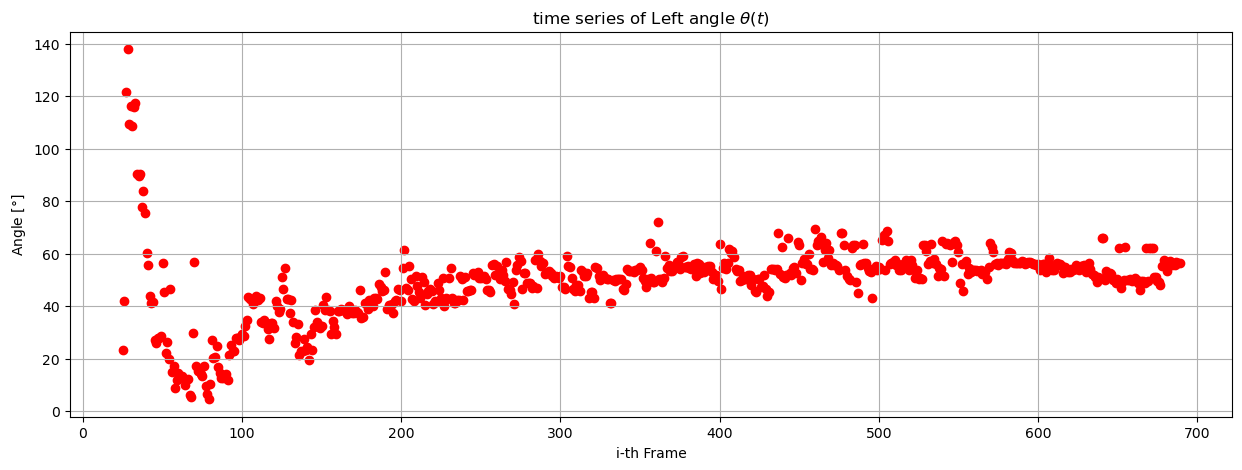

In [44]:
plt.figure(figsize=(15,5))
plt.scatter(i_left, theta_left, color = 'red')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("time series of Left angle $\\theta(t)$")
plt.grid(True)

## 3.2) Right Angle

In [92]:
angles_list = []

for i in tqdm(range(no_frames)):
    # Extract the 2D array
    data = processed_edges[0, i]

    # Find indices where values are greater than 0.8
    y, x = np.where(data > 0.8)

    if len(x) < 3000:
        pass 

    else:
        # Only consider upper half 
        x_upper = x[y <= half_line_y]
        y_upper = y[y <= half_line_y]

        # Only perform for the left side 
        quarter_point = -(-np.min(x_upper) + np.max(x_upper)) / 4 + np.max(x_upper)
        quarter_mask = [x_upper >= quarter_point][0]

        x_quarter = x_upper[quarter_mask]
        y_quarter = y_upper[quarter_mask]

        x_filtered = x_quarter[y_quarter <= half_line_y]
        y_filtered = y_quarter[y_quarter <= half_line_y]

        # Create points array
        points = np.vstack((x_filtered, y_filtered)).T

        # Compute the alpha shape with a suitable alpha value
        alpha = 0.1  #
        alpha_shape = alphashape.alphashape(points, alpha)
        if isinstance(alpha_shape, Polygon):
            x_edge, y_edge = alpha_shape.exterior.xy
        elif isinstance(alpha_shape, MultiPolygon):
            for poly in alpha_shape:
                x_edge, y_edge = poly.exterior.xy

        x_main_edge, y_main_edge = plot_extreme_x_points(x_edge, y_edge, 587)
        mask_middle = np.where( np.isclose(x_main_edge, quarter_point, atol= 1.5) )

        #Get all indices
        all_indices = np.arange(x_main_edge.shape[0])
        
        # Get indices that are not in mask_middle
        ind_not_middle = np.setdiff1d(all_indices, mask_middle)
        
        x_half = x_main_edge[ind_not_middle]
        y_half = y_main_edge[ind_not_middle]

        y_to_x = defaultdict(list)
        for x_v, y_v in zip(x_half, y_half):
            y_to_x[y_v].append(x_v)
        
        unique_y = np.array(sorted(y_to_x.keys()))
        unique_x = np.array([np.mean(y_to_x[y_v]) for y_v in unique_y])

        no_of_points = 20

        x_edge_points = unique_x[-no_of_points:]
        y_edge_points = unique_y[-no_of_points:]

        # Find the index of the maximum y value
        max_y_index = np.argmax(y_edge_points)
        max_x_point = x_edge_points[max_y_index]
        max_y_point = y_edge_points[max_y_index]

        '''Perform Iterative fitting for polynomials with degrees between 0 and 12'''

        # Initialize variables to store the best degree and its corresponding RMSE
        best_degree = 0
        best_rmse = float('inf')
        best_poly = None
        
        # Iterate through polynomial degrees from 0 to 12
        for degree in range(13):
        
                # Suppress the RankWarning for poorly conditioned polynomial fit
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', np.RankWarning)
                # Fit a polynomial to the data points
                coeffs = np.polyfit(y_edge_points, x_edge_points, degree)
            
            # Adjust the polynomial to pass through the (max_y_point, max_x_point)
            poly = np.poly1d(coeffs)
        
            # Evaluate the polynomial at the max_y_point
            x_at_max_y = poly(max_y_point)
        
            # Calculate the adjustment needed for the constant term
            adjustment = max_x_point - x_at_max_y
        
            # Create the adjusted polynomial
            coeffs[-1] += adjustment
            poly_adjusted = np.poly1d(coeffs)
        
            # Calculate the RMSE for the current polynomial
            x_pred = poly_adjusted(y_edge_points)
            rmse = np.sqrt(mean_squared_error(x_edge_points, x_pred))
        
            # Update the best degree and polynomial if the current RMSE is lower
            if rmse < best_rmse:
                best_rmse = rmse
                best_degree = degree
                best_poly = poly_adjusted

        # Create the fitted polynomial line using the best polynomial
        y_fit = np.linspace(np.min(y_edge_points), np.max(y_edge_points), 10)
        x_fit = best_poly(y_fit)

        index_min_x = np.argmax(y_fit)
        y_at_min_x = y_fit[index_min_x]

        # calculate the derivative at the point
        if index_min_x==0:
            dx_new = x_fit[0]-x_fit[1]
        
        if index_min_x > 0:
            dx_new = x_fit[index_min_x-1] - x_fit[index_min_x]
        
        if dx_new>0:
            dx = -dx_new
        if dx_new<0:
            dx = np.abs(dx_new)
        
        dy_dx = np.gradient(y_fit, dx)
        slope_at_min_x1 = dy_dx[index_min_x]

        angle_tangent_degrees_right  = np.degrees(np.arctan(slope_at_min_x1))
        # Measure angle on right side of interpolation 
        
        if angle_tangent_degrees_right < 0:
            angle = 180 + angle_tangent_degrees_right
        
        if angle_tangent_degrees_right > 0:
            angle = angle_tangent_degrees_right

        angles_list.append(angle)

100%|██████████| 690/690 [13:25<00:00,  1.17s/it]


In [94]:
angle_right = np.array(angles_list)
angle_right

array([123.8141679 ,  72.21371851, 142.71365963,  70.66225729,
       105.29494651, 106.0720475 , 114.16850047, 103.54399855,
       120.37085487,  90.42437701,  75.04536212,  80.17080017,
        65.0605686 ,  57.51816022,  60.90356976,  56.60099523,
        39.56577759,  39.91624852,  35.06476861,  59.36358005,
        55.67472721,  15.72871471,  20.40111193,  18.83606198,
        29.96954367,  17.89747858,  14.03359139,  16.49928269,
        17.63205469,  17.92246016,  16.61849238,   8.99938564,
        11.49885683,  17.78415494,  17.29547614,  10.97652449,
         6.61648537,   8.83898274,   9.76539529,   9.52226326,
         7.4682871 ,   7.74706662,  22.87261787,  18.92937846,
        14.5977622 ,  14.61426655,  13.88026264,  15.39606492,
        12.78161859,  14.05671368,  15.68791703,   9.42846113,
         6.95474672,  10.04642686,   7.91373543,   9.49987535,
        14.77054272,  14.61686923,  14.48279099,  23.03728541,
        16.81308087,  16.77185449,  14.86861625,  12.88

In [96]:
i_right = np.arange(25, no_frames, 1)

In [106]:
data1 = np.column_stack((i_right, angle_right))
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Right_angel_model2_july4.txt"
#np.savetxt(file_path, data1, delimiter='\t', header='i\tTheta')

In [108]:
file_path = r"C:\Users\josep\Desktop\Summer Research Project\Right_angel_model2_july4.txt"

# Load data
loaded_data = np.loadtxt(file_path, delimiter='\t', skiprows=1)  # Skip header row

# columns
i_right = loaded_data[:, 0]
theta_right = loaded_data[:, 1]

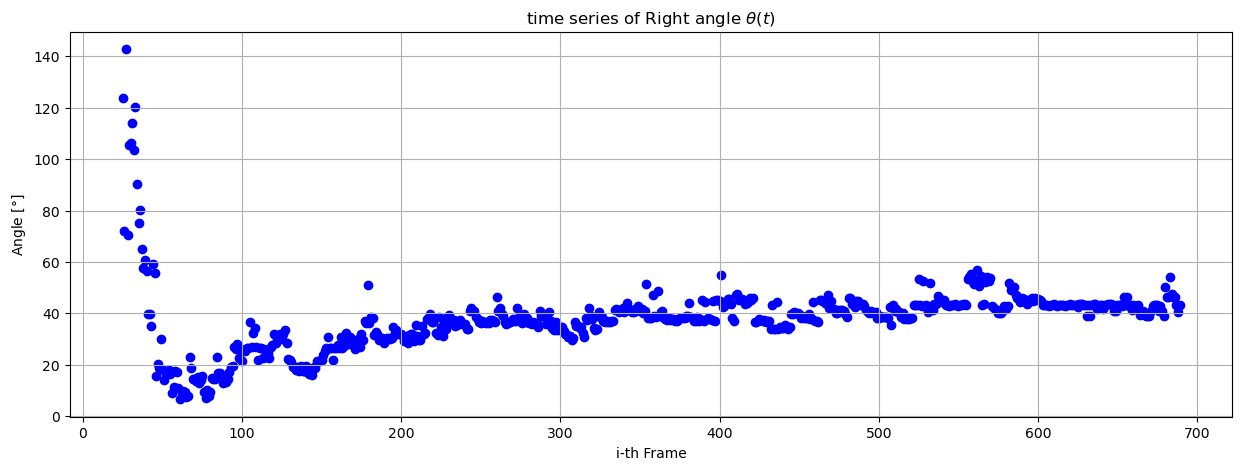

In [110]:
plt.figure(figsize=(15,5))
plt.scatter(i_right, theta_right, color = 'blue')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("time series of Right angle $\\theta(t)$")
plt.grid(True)

# 3.3) Compare 

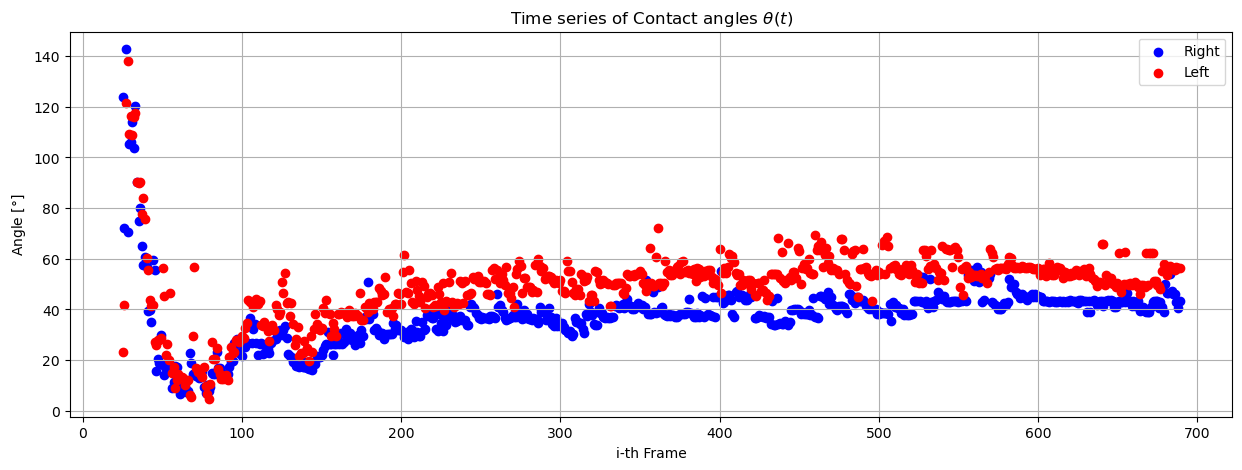

In [113]:
plt.figure(figsize=(15,5))
plt.scatter(i_right, theta_right, label = 'Right', color = 'blue')
plt.scatter(i_left, theta_left, label = 'Left', color = 'red')

plt.xlabel("i-th Frame")
plt.ylabel("Angle [$\degree$]")
plt.title("Time series of Contact angles $\\theta (t)$")
plt.grid(True)
plt.legend()

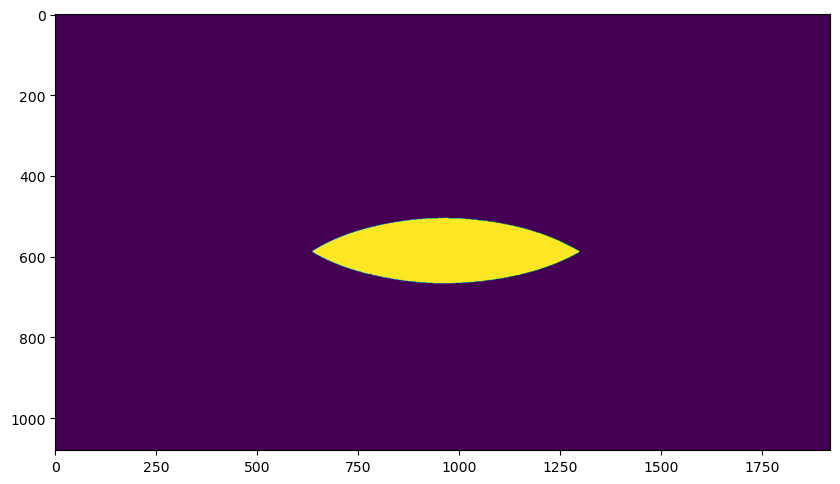

In [60]:
i = 200
plt.figure(figsize=(10,10))
plt.imshow(processed_edges[0, i], cmap='viridis')  

#plt.ylim(230, 0)

#plt.colorbar()  
plt.show()